# CAM / grad-CAM 구현해보기 실습 파일

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Mon Nov 13 01:54:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## CAM - grad CAM 실습을 위한 연습코드

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


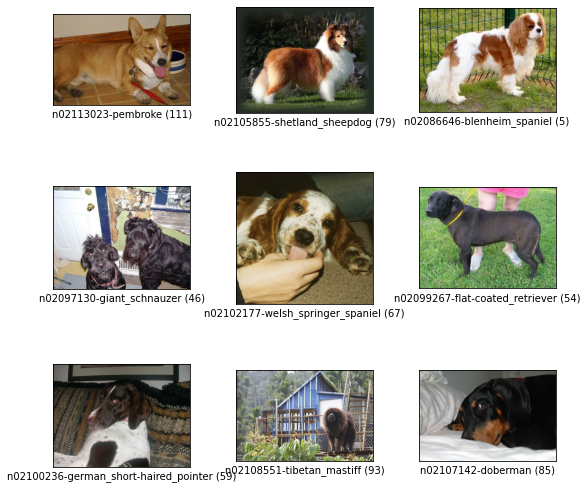

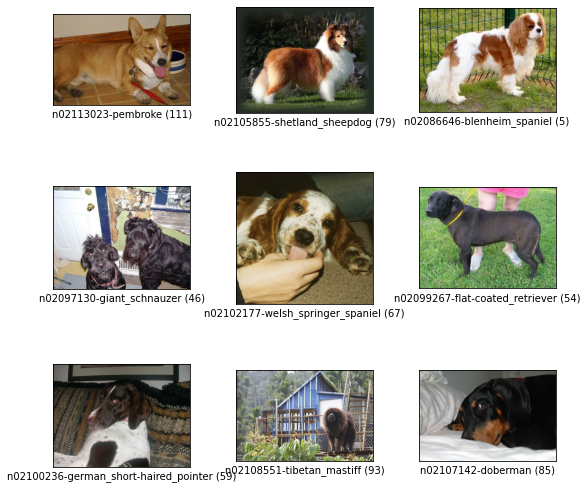

In [5]:
#show_example -> 이미지의 클래스, 인덱스 확인

#훈련 셋
tfds.show_examples(ds_train, ds_info)

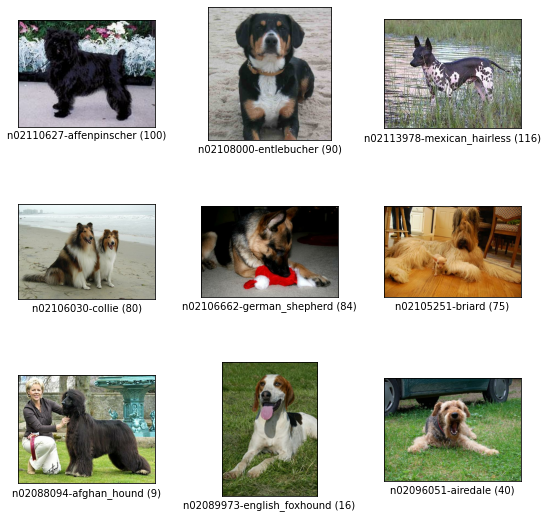

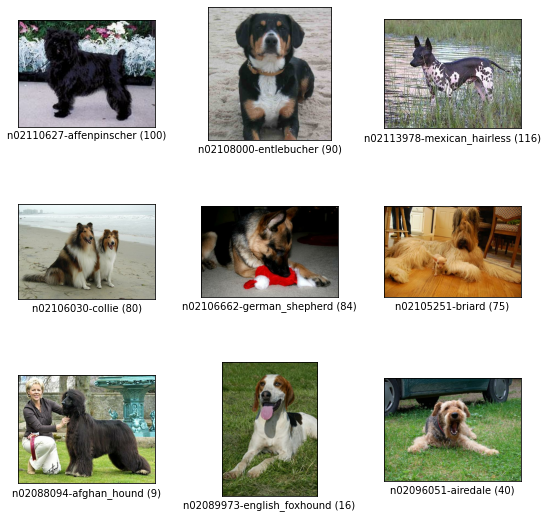

In [6]:
#테스트 셋
tfds.show_examples(ds_test, ds_info)

In [7]:
#feature구성 파악해보기

ds_info.features

#[ymin, xmin, ymax, xmax] bbox

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [9]:
# imagenet으로 학습된 resnet50

num_classes = ds_info.features["label"].num_classes

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [10]:
cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
#간단한 전처리

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [ ]:
#에폭 2로 간단하게 모델 학습시켜 가중치 저장해보기

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
import os

cam_model_path = '/aiffel/workspace/CAM'
cam_model.save(cam_model_path+'/cam_model1.h5')

## CAM 구현하기

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [2]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


11


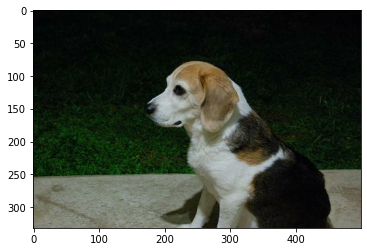

In [3]:
# 개별 이미지 단위 CAM를 위한 데이터 생성 + 테스트 데이터로 확인

def get_one(ds):
    #개별 이미지 단위
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()


In [6]:
#2에폭으로 학습된 가중치 load

import os
cam_model_path = os.getenv('HOME')+'/aiffel/workspace/CAM/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

### CAM 생성을 위해 필요한 입출력값

(1) 특성 맵,  
(2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치,  
(3) 원하는 클래스의 출력값

In [7]:
#model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

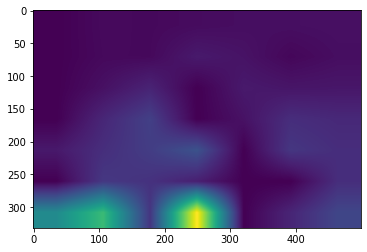

In [8]:
#CAM 확인

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [9]:
#그려진 CAM이미지 + 원본이미지 하는 함수

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

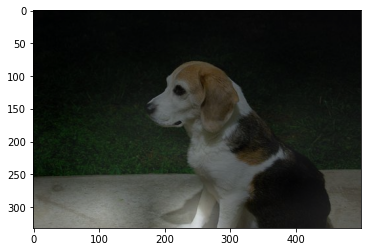

In [10]:
#겹쳐서 활성화 확인하기

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM 구현하기

최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해야한다.  

Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용하는 것이 포인트.

label : 116


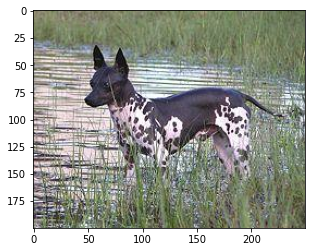

In [12]:
#새로운 test이미지 

item = get_one(ds_test)
print('label :',item['label'])
plt.imshow(item['image'])
plt.show()

In [13]:
# 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용하는 함수

def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

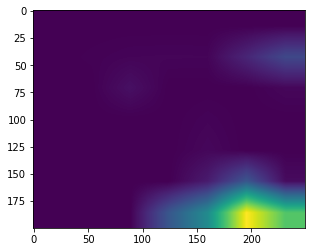

In [14]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

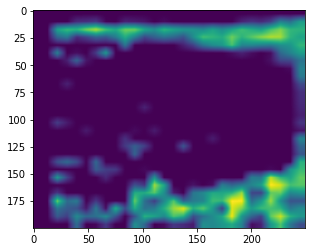

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

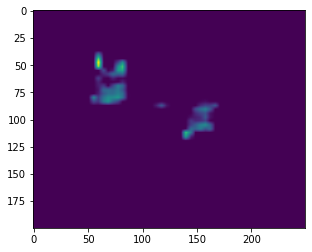

In [20]:
grad_cam_image = generate_grad_cam(cam_model, 'conv2_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## Detection with CAM

40


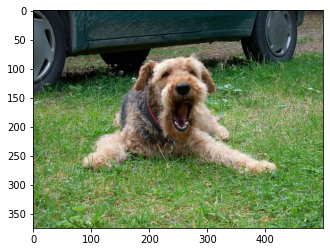

In [22]:
#새로운 이미지로 작업
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

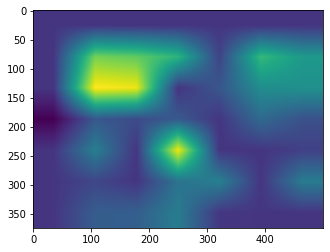

In [23]:
#cam 시각화

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- 바운딩 박스 만들기 위한 로직

score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.  
그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다.  
이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다.  
boxPoints()로 이를 꼭지점으로 바꿔주고, 마지막에는 int 자료형으로 변환한다

In [24]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [25]:
#bbox 좌표

rect = get_bbox(cam_image)
rect

array([[405, 243],
       [499, 243],
       [499, 338],
       [405, 338]])

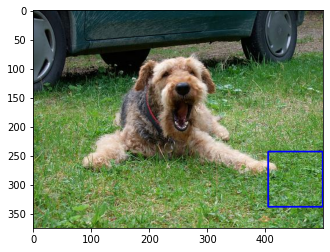

In [26]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 바운딩 박스의 성능을 비교/평가하는 방법 중 하나

### IoU(intersection over union)

두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값입니다.  
이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로,  
모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.

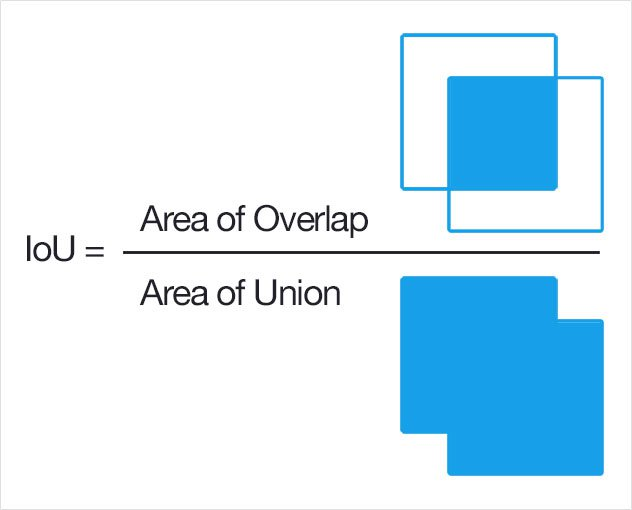

In [27]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
# 즉, rect 좌표 (x,y) 형태를 받아 minmax 형태로 반환

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [28]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.648, 0.81, 0.9013333333333333, 0.998]

In [29]:
#실제 bbox ground truth

item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [30]:
#IoU 계산

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [31]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.007377943535390025